In [3]:
import pandas as pd
from darts import TimeSeries
from darts.metrics import mape, r2_score, rmse
import numpy as np
from statsmodels.tsa.api import VAR, VARMAX


import utils


# Load data
df = utils.load_data()

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(
    covars_diff, should_diff=True, diff_order=1, should_scale=True, should_log=True
)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(
    covars_nodiff, should_diff=False, should_scale=True, should_log=True
)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(
    covars_diff_yoy, should_diff=True, diff_order=12, should_scale=True, should_log=True
)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True, diff_order=1, should_scale=True, should_log=True)


# Ensure that all timeseries are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_yoy_scaled)

# Stack the covariates
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(covars_diff_yoy_scaled)


# Split the data into training and validation sets
train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))


lags_past_covariates = {
        "US_UNEMPLOYMENT_RATE": [-3],
        "US_CPI": [-3],
        "US_TB_YIELD_3YRS": [-2],
        "YIELD_CURVE": [-1],
        "EXPINF10YR": [-1],
        "MICH": [-1],
        "US_TB_YIELD_5YRS": [-1],
        "NEWS_SENTIMENT": [-2],
        "SNP_500": [-1]
}

covariates_scaled = covariates_scaled.drop_columns([c for c in covariates_scaled.columns if c not in lags_past_covariates.keys()])




def make_multivariate_time_series(ts, covariates, only_cpi=True):
    if only_cpi:
        ts_multivariate = ts.slice_intersect(covariates).stack(covariates["US_CPI"])
    else:
        ts_multivariate = ts.slice_intersect(covariates).stack(covariates)

    # Split the data into training and validation sets
    train_ts_scaled, val_ts_scaled = ts_multivariate.split_after(pd.Timestamp("2016-01-01"))

    # Reconvert to DataFrame since statsmodels does not support TimeSeries objects^
    train = train_ts_scaled.to_dataframe()
    validation = val_ts_scaled.to_dataframe()
    history = pd.concat([train, validation])

    return train, validation, history


train, validation, history = make_multivariate_time_series(ts_scaled, covariates_scaled, only_cpi=False)

/Users/Xavier/portfolio/Forecasting_Interest_Rate_Fluctuations/utils.py:308: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start=start_date, end=end_date, progress=False)['Close']


# VAR Model

In [4]:
# For each time step in the validation set, fit a new model on the history so far and predict the next step
forecasts = pd.DataFrame()
for t in validation.index:

    # Get the history up to the previous month
    hist_t = history[:t - pd.offsets.MonthEnd()]
    # print(hist_t.iloc[-1])

    # Fit the model with data up to the previous month
    model = VAR(hist_t)
    model_fit = model.fit(maxlags=3)

    # Forecast for t + 1
    y_pred = model_fit.forecast(hist_t.values[-model_fit.k_ar:], steps=36)[:, 0]
    y_pred_unscaled = utils.unscale_series(TimeSeries.from_times_and_values(values=y_pred, times=pd.date_range(start=t, periods=36, freq="ME")), pipeline, ts_scaled["US_TB_YIELD_10YRS"])
    y_pred_unscaled = y_pred_unscaled.to_dataframe().rename(columns={"US_TB_YIELD_10YRS": "mean"})



    # print(y_pred.summary_frame())
    y_pred_unscaled["timestamp"] = t
    forecasts = pd.concat([forecasts, y_pred_unscaled])

forecasts['horizon'] = (forecasts.index.to_period("M") - forecasts.timestamp.dt.to_period("M")).map(lambda x: x.n + 1)
forecasts["true"] = ts["US_TB_YIELD_10YRS"].to_series()

# # Revert the scaling
# fore_unscaled = TimeSeries.from_dataframe(forecasts, value_cols=["mean"])

# # Plot the forecast
# fore_unscaled.plot(label="Forecast")
# val_ts.plot(label="True")

In [5]:
forecasts = forecasts.dropna()
forecasts["error"] = forecasts["true"] - forecasts["mean"]
forecasts["abs_error"] = forecasts["error"].abs()
forecasts["abs_pct_error"] = (forecasts["error"] / forecasts["true"]).abs()
forecasts.groupby("horizon").mean()[["abs_error", "abs_pct_error"]]

,abs_error,abs_pct_error
horizon,,
1,0.196780,0.111540
2,0.374962,0.218132
3,0.537722,0.315998
4,0.662338,0.384720
5,0.772830,0.435659
6,0.885029,0.485379
7,0.994523,0.536813
8,1.097333,0.585261
9,1.202027,0.634029


<Axes: xlabel='DATE'>

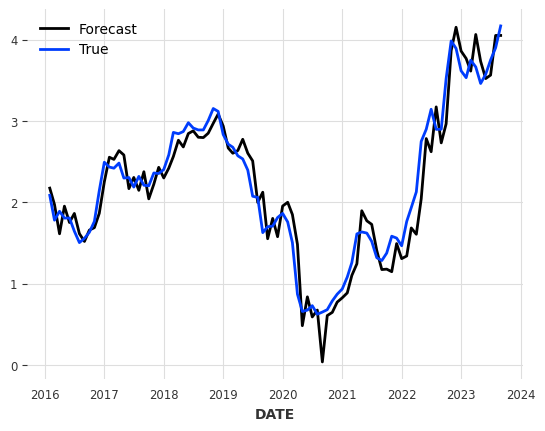

In [6]:
# Revert the scaling
fore_unscaled = TimeSeries.from_dataframe(forecasts[forecasts["horizon"] == 1], value_cols=["mean"])

# Plot the forecast
fore_unscaled.plot(label="Forecast")
val_ts.plot(label="True")

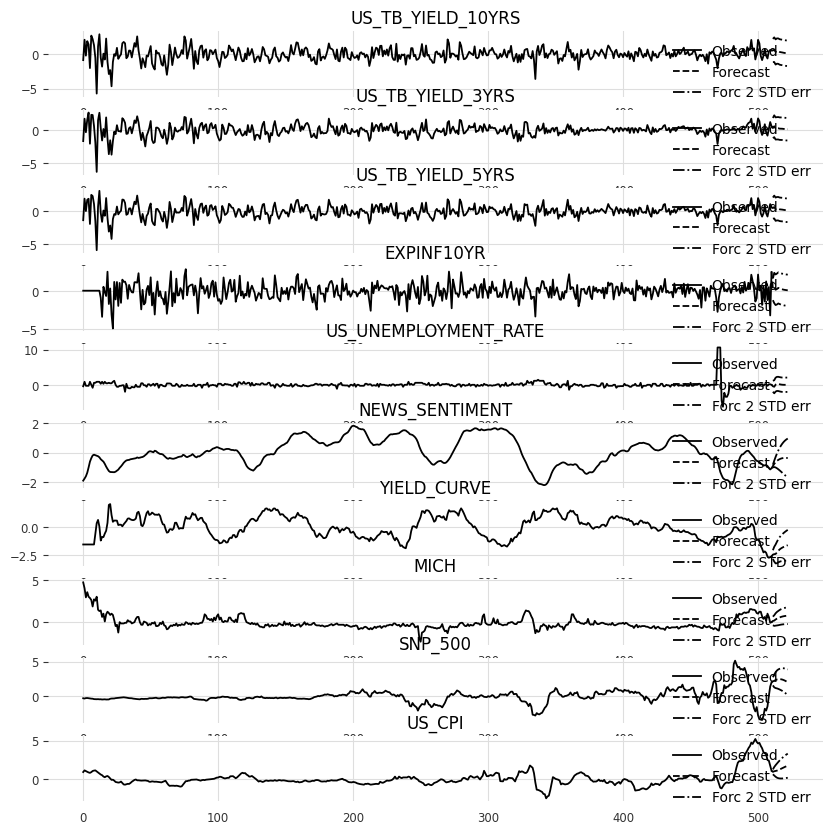

In [7]:
fig = model_fit.plot_forecast(steps=12)

# Test/Checks

In [8]:
test_result = model_fit.test_causality(caused='US_TB_YIELD_10YRS', causing=['US_CPI'], kind='f', signif=0.05)
test_result.summary()

Test statistic,Critical value,p-value,df
0.3133,2.607,0.816,"(3, 4770)"


In [9]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Nov, 2025
Time:                     16:45:14
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -24.7406
Nobs:                     508.000    HQIC:                  -26.3099
Log likelihood:           41.6330    FPE:                1.36388e-12
AIC:                     -27.3222    Det(Omega_mle):     7.54267e-13
--------------------------------------------------------------------
Results for equation US_TB_YIELD_10YRS
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -0.019960         0.039316           -0.508           0.612
L1.US_TB_YIELD_10YRS            0.084217         0.230831            0.365           0.715
L1.US_TB

In [10]:
norm = model_fit.test_normality()
norm.summary()

Test statistic,Critical value,p-value,df
9.608e+04,31.41,0.000,20


In [11]:
whiteness = model_fit.test_whiteness()
whiteness.summary()

Test statistic,Critical value,p-value,df
1056.,762.7,0.000,700


# SVAR

In [12]:
# Make 10x10 matrix with 0 on upper triangle, 1 on diagonal and "E" on lower triangle
# The matrix should be symmetric
n = len(train.columns)
matrix = np.zeros((n, n), dtype=object)
for i in range(n):
    for j in range(n):
        if i == j:
            matrix[i, j] = 1
        if i > j:
            matrix[i, j] = "E"
matrix

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       ['E', 1, 0, 0, 0, 0, 0, 0, 0, 0],
       ['E', 'E', 1, 0, 0, 0, 0, 0, 0, 0],
       ['E', 'E', 'E', 1, 0, 0, 0, 0, 0, 0],
       ['E', 'E', 'E', 'E', 1, 0, 0, 0, 0, 0],
       ['E', 'E', 'E', 'E', 'E', 1, 0, 0, 0, 0],
       ['E', 'E', 'E', 'E', 'E', 'E', 1, 0, 0, 0],
       ['E', 'E', 'E', 'E', 'E', 'E', 'E', 1, 0, 0],
       ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 1, 0],
       ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 1]], dtype=object)

In [13]:
import numpy as np
from statsmodels.tsa.api import SVAR
# Specify structural matrices
A = matrix  # Contemporaneous restrictions

# Fit the SVAR model
svar_model = SVAR(train, svar_type='A', A=A)  # Use 'B' for long-run restrictions
svar_results = svar_model.fit(maxlags=3, maxiter=10000, maxfun=10000)


/Users/Xavier/portfolio/Forecasting_Interest_Rate_Fluctuations/,/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Save plot to png
import matplotlib.pyplot as plt
# plt.savefig("irf_plot.png")


for r in ["US_CPI", "SNP_500", "US_UNEMPLOYMENT_RATE", "EXPINF10YR", "US_TB_YIELD_3YRS"]:
    svar_results.irf(periods=18).plot(impulse='US_TB_YIELD_10YRS', plot_stderr=True, response=r,
                         stderr_type='mc', repl=100)